In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM, GRU, Conv1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model

from IPython.display import Image

# Data Preprocessing

In [2]:
# weatherqc_dataset = pd.read_csv('Quezon City Weather 1983-2023.csv')
weatherqc_dataset = pd.read_csv('Quezon City Weather Data (Jan 2 1940 - May 20 2024).csv')
weatherqc_dataset.head()

,time,apparent_temperature_mean (°C)
0,1940-01-02,23.9
1,1940-01-03,24.3
2,1940-01-04,24.9
3,1940-01-05,26.4
4,1940-01-06,27.6


In [3]:
weatherqc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30821 entries, 0 to 30820
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            30821 non-null  object 
 1   apparent_temperature_mean (°C)  30821 non-null  float64
dtypes: float64(1), object(1)
memory usage: 481.7+ KB


In [4]:
weatherqc_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
apparent_temperature_mean (°C),30821.0,30.113838,2.487657,19.1,28.6,30.5,31.9,37.1


In [5]:
weatherqc_dataset.index = pd.to_datetime(weatherqc_dataset['time'])

<Axes: xlabel='time'>

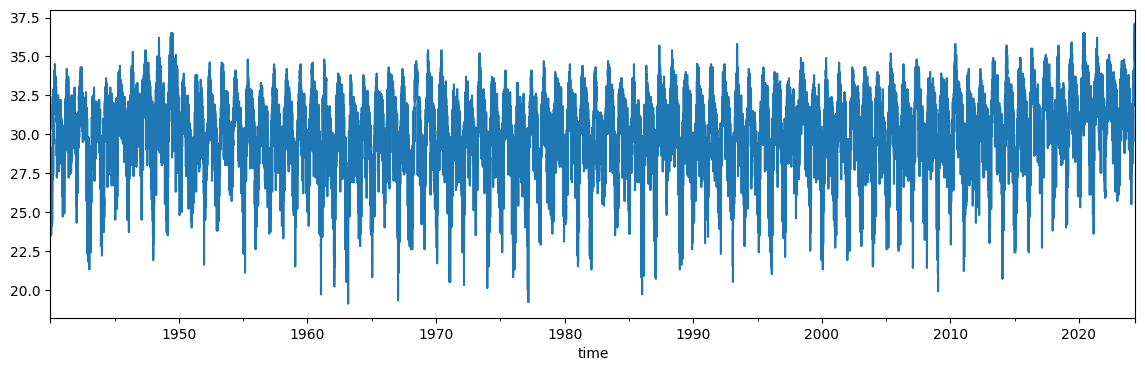

In [6]:
apparent_temp_mean = weatherqc_dataset['apparent_temperature_mean (°C)']
apparent_temp_mean.plot(figsize=(14, 4))

In [7]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X, y = [], []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    label = df_as_np[i+window_size]
    X.append(row)
    y.append(label)
  return np.array(X), np.array(y)
#input temp for previous 7 days [may 16-22]
#output 7 days forecast[may 23]

In [8]:
WINDOW_SIZE = 7
X, y = df_to_X_y(apparent_temp_mean, WINDOW_SIZE)
X.shape, y.shape
#y - labels, x - sequence of temp
#7 - weeek

((30814, 7, 1), (30814,))

In [9]:
# X_train, y_train = X[:8980], y[:8980]
# X_val, y_val = X[8981:11973], y[8981:11973]
# X_test, y_test = X[11974:], y[11974:]
# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
# #train - test split

X_train, y_train = X[:18488], y[:18488]
X_val, y_val = X[18489:24651], y[18489:24651]
X_test, y_test = X[24652:], y[24652:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
#train - test split

((18488, 7, 1), (18488,), (6162, 7, 1), (6162,), (6162, 7, 1), (6162,))

# Gru

In [10]:
gru_model = Sequential()
gru_model.add(InputLayer((7, 1))) #shape 7 since 7 days input
gru_model.add(GRU(64)) #neural network
gru_model.add(Dense(8, 'relu')) #layer
gru_model.add(Dense(1, 'linear')) #1 since output na siya, 1 node

gru_model.summary()
#neural network
#sequential and graphical


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #detect if di na nagbabago
model_checkpoint = ModelCheckpoint('gru_model.keras', monitor='val_loss', save_best_only=True) #model checkpoint
gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])#for metrics

In [12]:
history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
578/578 [==============================] - 19s 20ms/step - loss: 807.4686 - root_mean_squared_error: 28.4160 - val_loss: 666.4300 - val_root_mean_squared_error: 25.8153
Epoch 2/100
578/578 [==============================] - 5s 8ms/step - loss: 483.8116 - root_mean_squared_error: 21.9957 - val_loss: 324.7999 - val_root_mean_squared_error: 18.0222
Epoch 3/100
578/578 [==============================] - 6s 10ms/step - loss: 204.7831 - root_mean_squared_error: 14.3102 - val_loss: 110.1421 - val_root_mean_squared_error: 10.4949
Epoch 4/100
578/578 [==============================] - 6s 10ms/step - loss: 57.3947 - root_mean_squared_error: 7.5759 - val_loss: 23.7131 - val_root_mean_squared_error: 4.8696
Epoch 5/100
578/578 [==============================] - 10s 17ms/step - loss: 12.5821 - root_mean_squared_error: 3.5471 - val_loss: 7.1224 - val_root_mean_squared_error: 2.6688
Epoch 6/100
578/578 [==============================] - 8s 14ms/step - loss: 5.8497 - root_mean_squared_error

In [13]:
saved_gru_model = load_model('gru_model.keras') #

# Training

In [14]:
gru_model_train_predictions = saved_gru_model.predict(X_train).flatten() #for training
gru_model_train_results = pd.DataFrame(data={'GRU Train Predictions': gru_model_train_predictions, 'Actuals': y_train})
gru_model_train_results
#data frames

578/578 [==============================] - 2s 3ms/step


,GRU Train Predictions,Actuals
0,28.086487,28.7
1,28.818100,26.4
2,25.969135,25.6
3,26.250822,28.1
4,29.137577,28.8
...,...,...
18483,28.804602,28.5
18484,29.106745,26.6
18485,26.845592,27.0
18486,28.044901,27.7


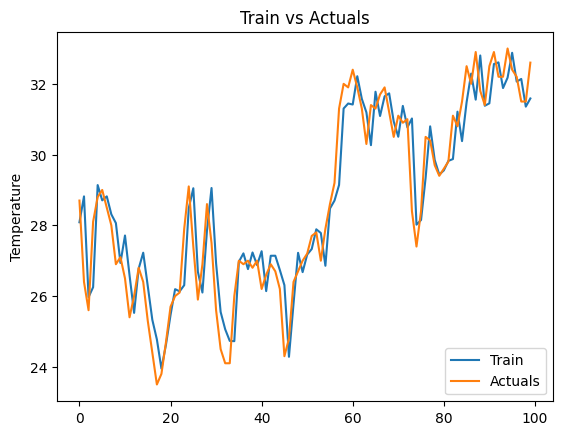

In [15]:
plt.plot(gru_model_train_results['GRU Train Predictions'][:100])
plt.plot(gru_model_train_results['Actuals'][:100])
plt.title('Train vs Actuals')
plt.ylabel('Temperature')
plt.legend(['Train', 'Actuals'], loc='lower right')

#plot

In [16]:
mse(y_train, gru_model_train_predictions)
#the higher the train mse compared to test, hindi siya overfitting

0.7797715567943925

# Validation

In [17]:
gru_model_val_predictions = saved_gru_model.predict(X_val).flatten()
gru_model_val_results = pd.DataFrame(data={'GRU Validation Predictions': gru_model_val_predictions, 'Actuals': y_val})
gru_model_val_results

193/193 [==============================] - 1s 3ms/step


,GRU Validation Predictions,Actuals
0,27.986126,28.0
1,28.086506,28.1
2,28.175390,28.1
3,28.154827,28.6
4,28.795771,27.7
...,...,...
6157,32.124367,31.5
6158,31.323761,33.3
6159,33.281277,33.6
6160,33.185539,33.4


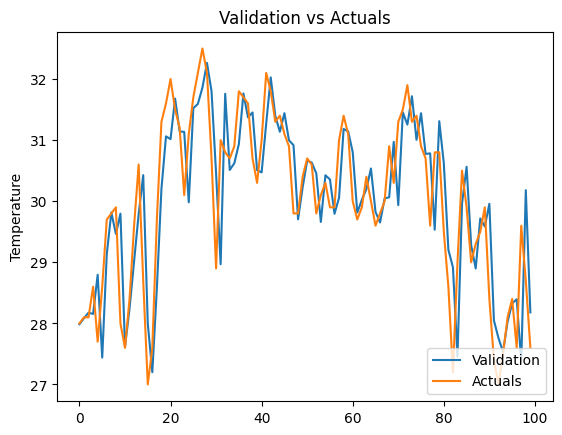

In [18]:
plt.plot(gru_model_val_results['GRU Validation Predictions'][:100])
plt.plot(gru_model_val_results['Actuals'][:100])
plt.title('Validation vs Actuals')
plt.ylabel('Temperature')
plt.legend(['Validation', 'Actuals'], loc='lower right')

In [19]:
mse(y_val, gru_model_val_predictions) #mean squared error
#the lower the better
#belo 1 c is good

0.8441967593938395

# Testing

In [20]:
gru_model_test_predictions = saved_gru_model.predict(X_test).flatten()
gru_model_test_results = pd.DataFrame(data={'GRU Test Predictions': gru_model_test_predictions, 'Actuals': y_test})
gru_model_test_results,

193/193 [==============================] - 1s 3ms/step


(      GRU Test Predictions  Actuals
 0                32.206734     31.1
 1                30.920483     31.4
 2                31.636383     30.3
 3                30.112455     30.8
 4                31.176094     30.0
 ...                    ...      ...
 6157             34.386517     34.9
 6158             34.446224     34.7
 6159             34.275703     35.2
 6160             34.613213     34.8
 6161             34.293278     35.1
 
 [6162 rows x 2 columns],)

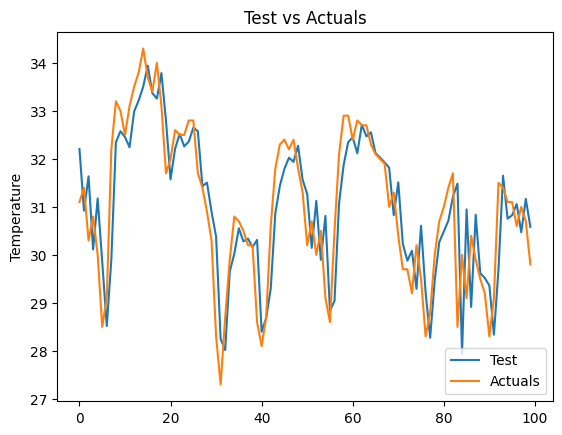

In [21]:
plt.plot(gru_model_test_results['GRU Test Predictions'][:100])
plt.plot(gru_model_test_results['Actuals'][:100])
plt.title('Test vs Actuals')
plt.ylabel('Temperature')
plt.legend(['Test', 'Actuals'], loc='lower right')

In [22]:
mse(y_test, gru_model_test_predictions)
#

0.884149795093946

# Gru MSE Summary

In [ ]:
print("========= GRU MSE Summary =========")
print("Train MSE:", mse(y_train, gru_model_train_predictions))
print("Validation MSE:", mse(y_test, gru_model_val_predictions))
print("Test MSE:", mse(y_test, gru_model_test_predictions))

In [23]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('gru_model.keras')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
#loss rmse - root mean squared error


193/193 [==============================] - 1s 3ms/step - loss: 0.8841 - root_mean_squared_error: 0.9403
Test Loss: [0.8841497898101807, 0.9402924180030823]


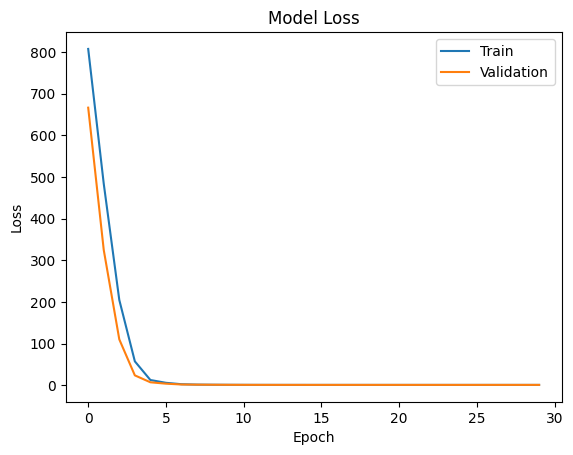

In [24]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [26]:
diff = mse(y_train, gru_model_train_predictions) - mse(y_test, gru_model_test_predictions)
increase = (diff / mse(y_test, gru_model_test_predictions)) * 100
increase
# 10 - 20 is good
# < 10 is excellent

-11.805492562316628

In [27]:
forecast_temp = []


user_input_past_temp = np.array([float(input("Prompt mean apparent temperature for the previous seven days: ")) for i in range(7)]).reshape(1, 7, 1)

# user_input_past_temp for seven days = np.array([31.2, 32.6, 33.2, 32.9, 32.6, 32.9, 32.2]).reshape(1, 7, 1)
# actual next seven days =                       [32.2, 32.8, 32.2, 31.9, 31.9, 31.9, 32.0]
# predicted =                                  ~ [32.0154, 32.029522, 31.978558, 31.883726, 31.795433, 31.715725, 31.638308]

for i in range(7):
  predictions = saved_gru_model.predict(user_input_past_temp)
  prediction = predictions[0][0]
  forecast_temp.append(prediction)
  user_input_past_temp = np.delete(user_input_past_temp, 0, axis=1)
  user_input_past_temp = np.append(user_input_past_temp, prediction).reshape(1, 7, 1)

print(f'Mean Apparent Temperature for the next seven days: {forecast_temp}')

Prompt mean apparent temperature for the previous seven days: 20
Prompt mean apparent temperature for the previous seven days: 34
Prompt mean apparent temperature for the previous seven days: 43
Prompt mean apparent temperature for the previous seven days: 34
Prompt mean apparent temperature for the previous seven days: 44
Prompt mean apparent temperature for the previous seven days: 31
Prompt mean apparent temperature for the previous seven days: 32
1/1 [==============================] - 0s 26ms/step
Mean Apparent Temperature for the next seven days: [32.463352, 32.511013, 32.460133, 32.38449, 32.263084, 32.119797, 32.00184]


In [28]:
# INSERT HEAT INDEX CLASSIFICATION
# General classification based on the National Weather Service (NWS)
# CAUTION               27-32 C
# EXTREME CAUTION       33-39 C
# DANGER                40-51 C
# EXTREME DANGER        52 C and above

def heat_index_classification(index):
  """
  Takes in index (element from forecast_temp list)
  Outputs NWS classification
  """
  if 27 <= index <= 32:
    return 'CAUTION'
  elif 33 <= index <= 39:
    return 'EXTREME CAUTION'
  elif 40 <= index <= 51:
    return 'DANGER'
  elif index >= 52:
    return 'EXTREME DANGER'

heat_index_classification(37) # map to list

'EXTREME CAUTION'

# Conv 1d

In [41]:
# Create model
conv1d_model = Sequential()
conv1d_model.add(InputLayer((7, 1)))
conv1d_model.add(Conv1D(64, kernel_size=3, activation='relu'))
# conv1d_model.add(Dropout(0.0005)) #0.1, 0.05, 0.2
conv1d_model.add(Flatten())
conv1d_model.add(Dense(8, 'relu'))
conv1d_model.add(Dense(1, 'linear'))

conv1d_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 64)             256       
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 2568      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2833 (11.07 KB)
Trainable params: 2833 (11.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
conv1d_cp = ModelCheckpoint('conv1d_model_1940_may2024.keras', save_best_only=True)
conv1d_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [43]:
history_conv1d = conv1d_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping, conv1d_cp])

Epoch 1/100
578/578 [==============================] - 3s 3ms/step - loss: 568.6792 - root_mean_squared_error: 23.8470 - val_loss: 39.3637 - val_root_mean_squared_error: 6.2740
Epoch 2/100
578/578 [==============================] - 2s 4ms/step - loss: 4.7718 - root_mean_squared_error: 2.1844 - val_loss: 2.2790 - val_root_mean_squared_error: 1.5096
Epoch 3/100
578/578 [==============================] - 3s 5ms/step - loss: 2.0688 - root_mean_squared_error: 1.4383 - val_loss: 2.2182 - val_root_mean_squared_error: 1.4894
Epoch 4/100
578/578 [==============================] - 2s 4ms/step - loss: 1.9537 - root_mean_squared_error: 1.3978 - val_loss: 2.0791 - val_root_mean_squared_error: 1.4419
Epoch 5/100
578/578 [==============================] - 2s 3ms/step - loss: 1.8401 - root_mean_squared_error: 1.3565 - val_loss: 1.9931 - val_root_mean_squared_error: 1.4118
Epoch 6/100
578/578 [==============================] - 2s 3ms/step - loss: 1.7356 - root_mean_squared_error: 1.3174 - val_loss: 1.8

In [44]:
saved_conv1d_model = load_model('conv1d_model_1940_may2024.keras')

# Training

In [45]:
conv1d_model_train_predictions = saved_conv1d_model.predict(X_train).flatten()
conv1d_model_train_results = pd.DataFrame(data={'Conv1d Train Predictions': conv1d_model_train_predictions, 'Actuals': y_train})
conv1d_model_train_results

578/578 [==============================] - 1s 2ms/step


,Conv1d Train Predictions,Actuals
0,27.994175,28.7
1,28.294641,26.4
2,26.476101,25.6
3,25.778481,28.1
4,28.615883,28.8
...,...,...
18483,29.570677,28.5
18484,28.720112,26.6
18485,27.460449,27.0
18486,27.485706,27.7


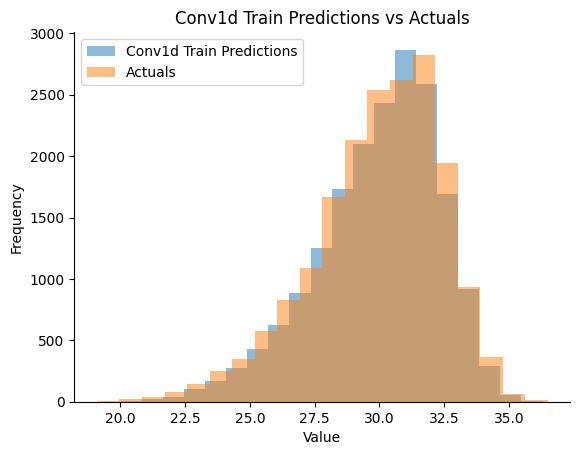

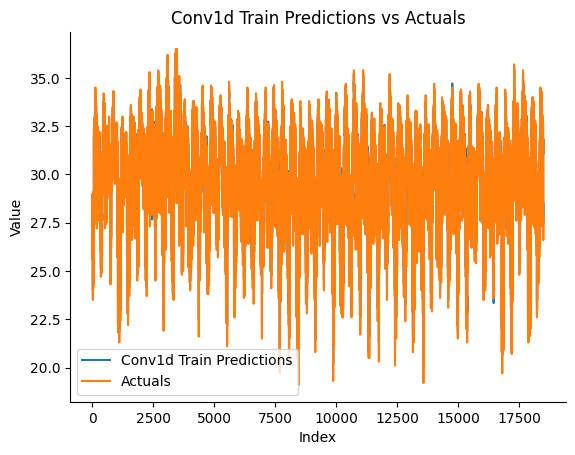

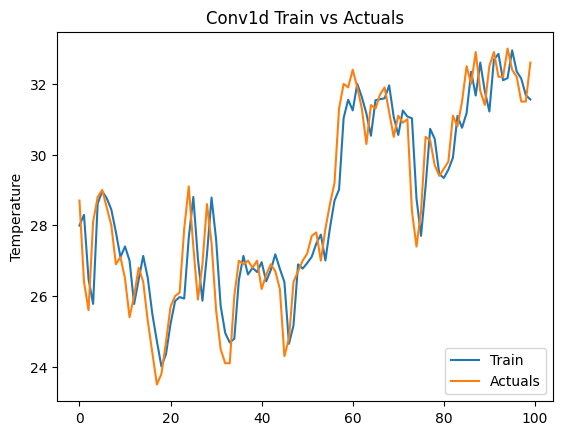

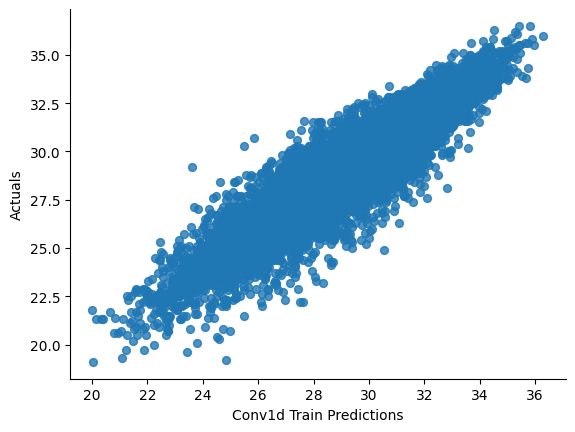

In [46]:
# Conv1d Train Predictions vs Actuals Histogram
from matplotlib import pyplot as plt
conv1d_model_train_results['Conv1d Train Predictions'].plot(kind='hist', bins=20, alpha=0.5, label='Conv1d Train Predictions')
conv1d_model_train_results['Actuals'].plot(kind='hist', bins=20, alpha=0.5, label='Actuals')
plt.title('Conv1d Train Predictions vs Actuals')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Conv1d train predictions vs actuals line (all)
from matplotlib import pyplot as plt
conv1d_model_train_results['Conv1d Train Predictions'].plot(kind='line', label='Conv1d Train Predictions')
conv1d_model_train_results['Actuals'].plot(kind='line', label='Actuals')
plt.title('Conv1d Train Predictions vs Actuals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Conv1d train predictions vs actuals line (segment only)
plt.plot(conv1d_model_train_results['Conv1d Train Predictions'][:100])
plt.plot(conv1d_model_train_results['Actuals'][:100])
plt.title('Conv1d Train vs Actuals')
plt.ylabel('Temperature')
plt.legend(['Train', 'Actuals'], loc='lower right')

# Conv1d Train Predictions vs Actuals Scatter Plot
from matplotlib import pyplot as plt
conv1d_model_train_results.plot(kind='scatter', x='Conv1d Train Predictions', y='Actuals', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Validation

In [47]:
conv1d_model_val_predictions = saved_conv1d_model.predict(X_val).flatten()
conv1d_model_val_results = pd.DataFrame(data={'Conv1d Validation Predictions': conv1d_model_val_predictions, 'Actuals': y_val})
conv1d_model_val_results

193/193 [==============================] - 1s 3ms/step


,Conv1d Validation Predictions,Actuals
0,28.054193,28.0
1,28.023872,28.1
2,28.072149,28.1
3,28.142086,28.6
4,28.619522,27.7
...,...,...
6157,32.324226,31.5
6158,31.540953,33.3
6159,33.268852,33.6
6160,33.607910,33.4


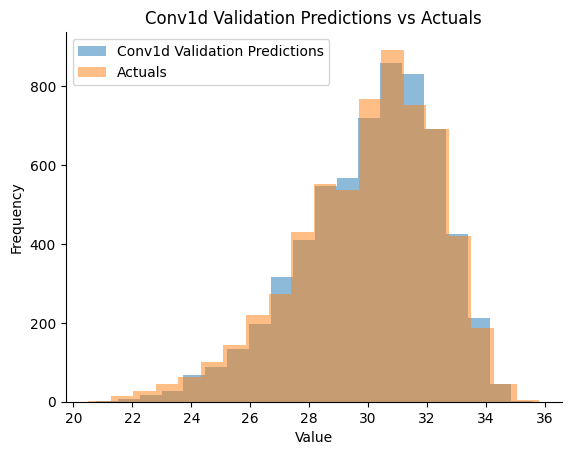

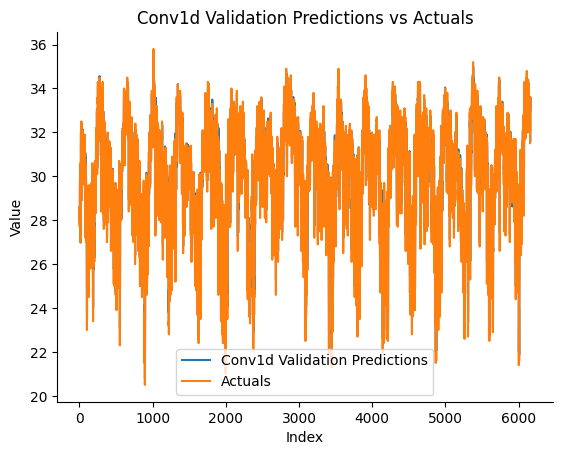

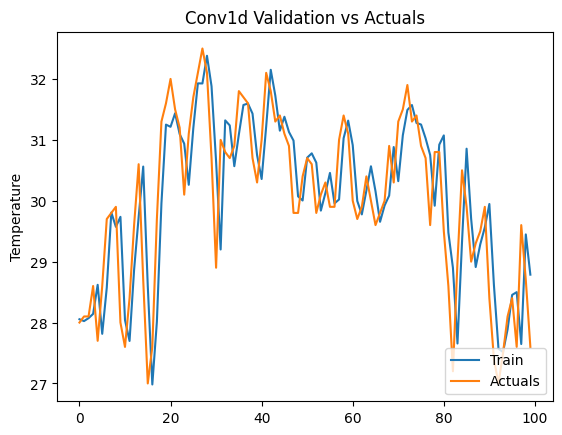

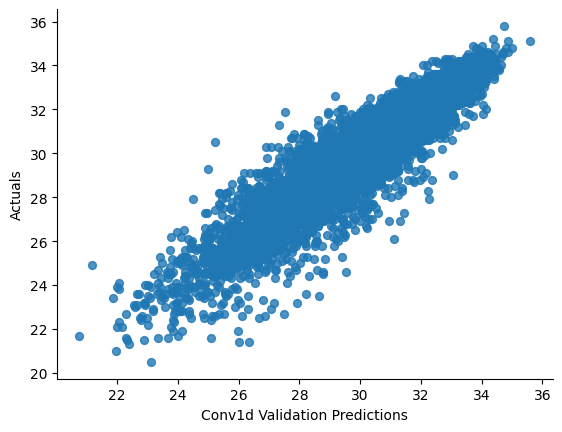

In [48]:
# Conv1d validation Predictions vs Actuals Histogram
from matplotlib import pyplot as plt
conv1d_model_val_results['Conv1d Validation Predictions'].plot(kind='hist', bins=20, alpha=0.5, label='Conv1d Validation Predictions')
conv1d_model_val_results['Actuals'].plot(kind='hist', bins=20, alpha=0.5, label='Actuals')
plt.title('Conv1d Validation Predictions vs Actuals')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Conv1d validation predictions vs actuals line (all)
conv1d_model_val_results['Conv1d Validation Predictions'].plot(kind='line', label='Conv1d Validation Predictions')
conv1d_model_val_results['Actuals'].plot(kind='line', label='Actuals')
plt.title('Conv1d Validation Predictions vs Actuals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Conv1d validation predictions vs actuals line (segment only)
plt.plot(conv1d_model_val_results['Conv1d Validation Predictions'][:100])
plt.plot(conv1d_model_val_results['Actuals'][:100])
plt.title('Conv1d Validation vs Actuals')
plt.ylabel('Temperature')
plt.legend(['Train', 'Actuals'], loc='lower right')

# Conv1d validation Predictions vs Actuals Scatter Plot
conv1d_model_val_results.plot(kind='scatter', x='Conv1d Validation Predictions', y='Actuals', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Testing

In [49]:
conv1d_model_test_predictions = saved_conv1d_model.predict(X_test).flatten()
conv1d_model_test_results = pd.DataFrame(data={'Conv1d Test Predictions': conv1d_model_test_predictions, 'Actuals': y_test})
conv1d_model_test_results

193/193 [==============================] - 1s 3ms/step


,Conv1d Test Predictions,Actuals
0,32.030220,31.1
1,31.424461,31.4
2,31.572418,30.3
3,30.781197,30.8
4,30.907448,30.0
...,...,...
6157,35.071285,34.9
6158,34.888432,34.7
6159,34.881401,35.2
6160,35.213562,34.8


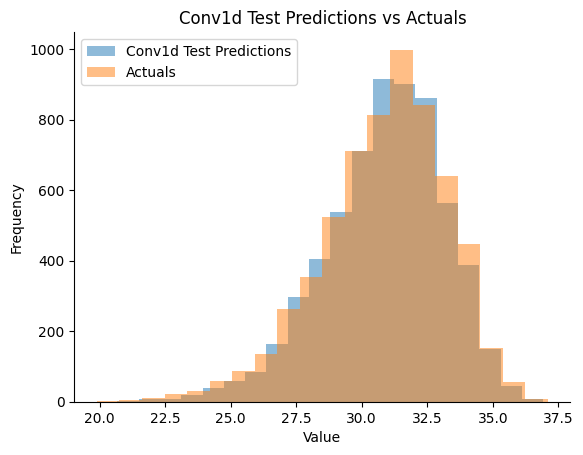

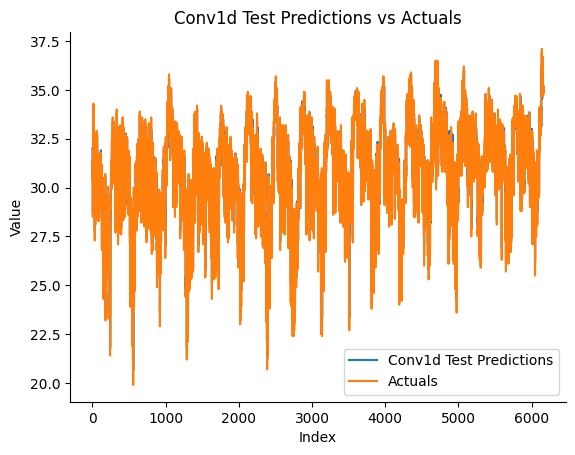

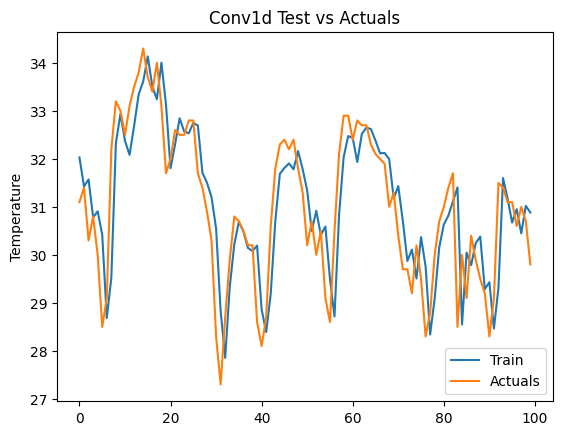

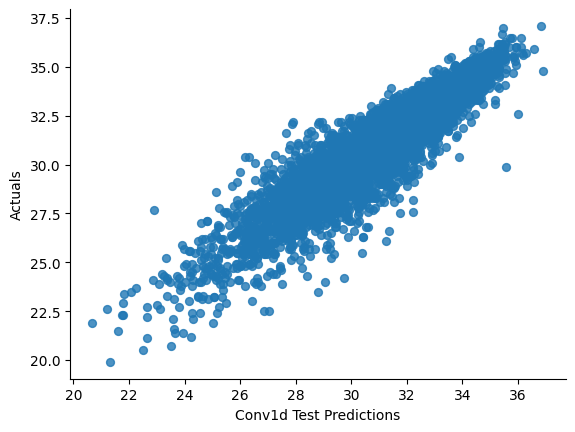

In [50]:
# Conv1d Test Predictions vs Actuals Histogram
from matplotlib import pyplot as plt
conv1d_model_test_results['Conv1d Test Predictions'].plot(kind='hist', bins=20, alpha=0.5, label='Conv1d Test Predictions')
conv1d_model_test_results['Actuals'].plot(kind='hist', bins=20, alpha=0.5, label='Actuals')
plt.title('Conv1d Test Predictions vs Actuals')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Conv1d test predictions vs actuals line (all)
conv1d_model_test_results['Conv1d Test Predictions'].plot(kind='line', label='Conv1d Test Predictions')
conv1d_model_test_results['Actuals'].plot(kind='line', label='Actuals')
plt.title('Conv1d Test Predictions vs Actuals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Conv1d test predictions vs actuals line (segment only)
plt.plot(conv1d_model_test_results['Conv1d Test Predictions'][:100])
plt.plot(conv1d_model_test_results['Actuals'][:100])
plt.title('Conv1d Test vs Actuals')
plt.ylabel('Temperature')
plt.legend(['Train', 'Actuals'], loc='lower right')

# Conv1d Test Predictions vs Actuals Scatter Plot
conv1d_model_test_results.plot(kind='scatter', x='Conv1d Test Predictions', y='Actuals', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Conv1d MSE Summary

In [51]:
print("======= CONV1D MSE SUMMARY ========")
print("Train MSE:", mse(y_train, conv1d_model_train_predictions))
print("Validation MSE:", mse(y_val, conv1d_model_val_predictions))
print("Test MSE:", mse(y_test, conv1d_model_test_predictions)) #overfit, train mse is higher than test

======= CONV1D MSE SUMMARY ========
Train MSE: 0.8467045038258095
Validation MSE: 0.9321985906953048
Test MSE: 0.9324465347161494


In [52]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('conv1d_model.keras')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

193/193 [==============================] - 1s 5ms/step - loss: 0.9635 - root_mean_squared_error: 0.9816
Test Loss: [0.9635412693023682, 0.981601357460022]


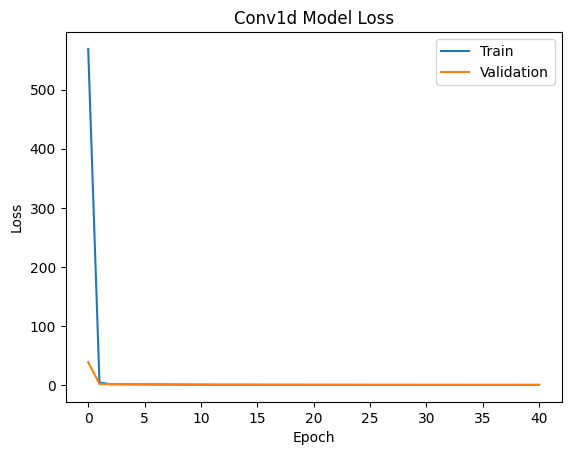

In [53]:
# Plot training & validation loss values
plt.plot(history_conv1d.history['loss'])
plt.plot(history_conv1d.history['val_loss'])
plt.title('Conv1d Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [54]:
diff = mse(y_train, conv1d_model_train_predictions) - mse(y_test, conv1d_model_test_predictions)
increase = (diff / mse(y_test, conv1d_model_test_predictions)) * 100
increase
# 10 - 20 is good
# < 10 is excellent

-9.195383080751219

# LSTM

In [58]:
lstm_model = Sequential()
lstm_model.add(InputLayer((7, 1)))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(8, 'relu'))
lstm_model.add(Dense(1, 'linear'))

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_cp = ModelCheckpoint('lstm_model_1940_may2024.keras', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [61]:
history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping, lstm_cp])

Epoch 1/100
578/578 [==============================] - 6s 10ms/step - loss: 0.7839 - root_mean_squared_error: 0.8854 - val_loss: 0.8832 - val_root_mean_squared_error: 0.9398
Epoch 2/100
578/578 [==============================] - 4s 8ms/step - loss: 0.7836 - root_mean_squared_error: 0.8852 - val_loss: 0.8548 - val_root_mean_squared_error: 0.9246
Epoch 3/100
578/578 [==============================] - 5s 8ms/step - loss: 0.7849 - root_mean_squared_error: 0.8859 - val_loss: 0.8444 - val_root_mean_squared_error: 0.9189
Epoch 4/100
578/578 [==============================] - 6s 10ms/step - loss: 0.7857 - root_mean_squared_error: 0.8864 - val_loss: 0.8560 - val_root_mean_squared_error: 0.9252
Epoch 5/100
578/578 [==============================] - 4s 8ms/step - loss: 0.7840 - root_mean_squared_error: 0.8854 - val_loss: 0.8485 - val_root_mean_squared_error: 0.9211
Epoch 6/100
578/578 [==============================] - 4s 7ms/step - loss: 0.7836 - root_mean_squared_error: 0.8852 - val_loss: 0.851

In [62]:
saved_lstm_model = load_model('lstm_model_1940_may2024.keras')

# Training

In [63]:
lstm_model_train_predictions = saved_lstm_model.predict(X_train).flatten() #for training
lstm_model_train_results = pd.DataFrame(data={'LSTM Train Predictions': lstm_model_train_predictions, 'Actuals': y_train})
lstm_model_train_results
#data frames

578/578 [==============================] - 3s 4ms/step


,LSTM Train Predictions,Actuals
0,27.891504,28.7
1,28.551359,26.4
2,25.816589,25.6
3,26.104269,28.1
4,29.072716,28.8
...,...,...
18483,28.860487,28.5
18484,28.963268,26.6
18485,26.785679,27.0
18486,27.935568,27.7


# Validation

In [64]:
lstm_model_val_predictions = saved_lstm_model.predict(X_val).flatten()
lstm_model_val_results = pd.DataFrame(data={'LSTM Validation Predictions': lstm_model_val_predictions, 'Actuals': y_val})
lstm_model_val_results

193/193 [==============================] - 1s 6ms/step


,LSTM Validation Predictions,Actuals
0,28.007225,28.0
1,28.022621,28.1
2,28.096134,28.1
3,28.102440,28.6
4,28.725546,27.7
...,...,...
6157,32.108727,31.5
6158,31.333637,33.3
6159,33.370335,33.6
6160,33.118835,33.4


# Testing

In [65]:
lstm_model_test_predictions = saved_lstm_model.predict(X_test).flatten()
lstm_model_test_results = pd.DataFrame(data={'LSTM Test Predictions': lstm_model_test_predictions, 'Actuals': y_test})
lstm_model_test_results

193/193 [==============================] - 1s 3ms/step


,LSTM Test Predictions,Actuals
0,32.145054,31.1
1,31.009621,31.4
2,31.661724,30.3
3,30.209469,30.8
4,31.137354,30.0
...,...,...
6157,34.565517,34.9
6158,34.629932,34.7
6159,34.423153,35.2
6160,34.820011,34.8


# LSTM MSE Summary

In [66]:
print("======= LSTM MSE SUMMARY ========")
print("Train MSE:", mse(y_train, lstm_model_train_predictions))
print("Validation MSE:", mse(y_val, lstm_model_val_predictions))
print("Test MSE:", mse(y_test, lstm_model_test_predictions)) #overfit, train mse is higher than test

======= LSTM MSE SUMMARY ========
Train MSE: 0.7772233128076208
Validation MSE: 0.8443639879800223
Test MSE: 0.8783501548595192


In [67]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('lstm_model_1940_may2024.keras')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss of LSTM Model:", test_loss)

193/193 [==============================] - 1s 3ms/step - loss: 0.8783 - root_mean_squared_error: 0.9372
Test Loss of LSTM Model: [0.8783496022224426, 0.937203049659729]


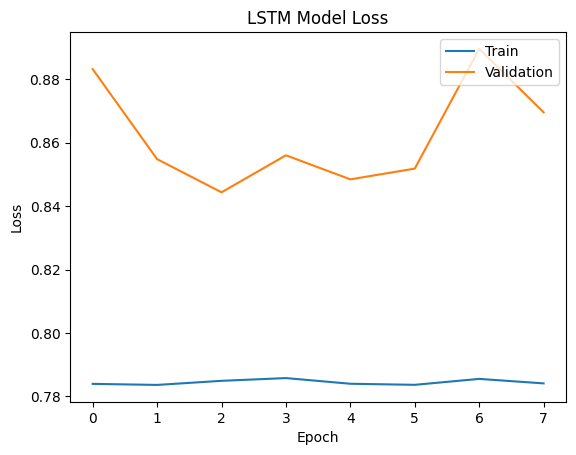

In [68]:
# Plot training & validation loss values
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [69]:
diff = mse(y_train, lstm_model_train_predictions) - mse(y_test, lstm_model_test_predictions)
increase = (diff / mse(y_test, lstm_model_test_predictions)) * 100
increase
# 10 - 20 is good
# < 10 is excellent

-11.51327195565558